In [118]:
import os
import pandas as pd
import pickle
file1 = "/Users/elliotschumacher/Dropbox/git/clel/results/run_2020_04_08_22_29_11_ALL_r3n03/eval_199.xlsx"
#file2 should be the ZS version
#file2 = "/Users/elliotschumacher/Dropbox/git/clel/results/run_2020_04_07_21_56_54_ALL_r7n01/eval_249.xlsx"
#file2 = "/Users/elliotschumacher/Dropbox/git/clel/results/run_2020_04_14_21_44_04_ALL_r3n05/eval_249.xlsx"
file2 = "/Users/elliotschumacher/Dropbox/git/clel/results/run_2020_04_15_10_05_53_ALL_r2n04/eval_249.xlsx"
heldout_lang = ["SPA", "CMN"]
with open('/Users/elliotschumacher/Dropbox/git/clel/results/run_2020_04_15_10_05_53_ALL_r2n04/training_ENG.pkl', 'rb') as f:
    training_entities = pickle.load(f)
data_file = "/Users/elliotschumacher/Dropbox/git/clel/datasets/LDC2019T02/ENG/tac_kbp_2015_tedl_training_gold_standard_entity_mentions.tab"
header_list = ["system_id", "query_id", "mention_string", "doc_id_offsets", "link_id", "entity_type", "mention_type",
               "confidence", "web_search", "wiki_text", "unknown"]
df_a = pd.read_excel(file1)
df_b = pd.read_excel(file2)
data = pd.read_csv(data_file, sep="\t", names=header_list, header=None,)

same = ["_text",
        "_sentence",
        "_gold_kbid",
        "_num_kb_cands",
        "~~mention_uuid",
        "~~comm",
        "_gold_name",
        ]
new_columns = ["lang", "train_eng", "train_cmn", "train_spa"]
column_renames_a = {}
column_renames_b = {}
new_columns.extend(same)

for col in df_a.columns:
    if col not in same:
        new_columns.append(col + "_A")
        new_columns.append(col + "_B")
        column_renames_a[col] = col + "_A"
        column_renames_b[col] = col + "_B"

df_a = df_a.rename(columns=column_renames_a)
df_b = df_b.rename(columns=column_renames_b)


df_both_correct = pd.DataFrame(columns=new_columns)
df_a_correct = pd.DataFrame(columns=new_columns)
df_b_correct = pd.DataFrame(columns=new_columns)
df_none_correct = pd.DataFrame(columns=new_columns)
eval_mentions = set()
for i, row_a in df_a.iterrows():
    eval_mentions.add(row_a['~~mention_uuid'])

data = data[~data.query_id.isin(eval_mentions)]
data = data[~data['link_id'].str.startswith('NIL')]
data['lang'] = data.apply(lambda row: row.doc_id_offsets[:3], axis = 1)

link_lang_pivot = pd.pivot_table(data, index=['link_id', 'lang'], values='query_id', aggfunc=len).reset_index()
#data2 = data[~data.lang.isin(heldout_lang)]
data2 = data[data['query_id'].isin(training_entities)]
link_lang_pivot2 = pd.pivot_table(data2, index=['link_id', 'lang'], values='query_id', aggfunc=len).reset_index()

link_lang_results = []


for i, row_a in df_a.iterrows():
    if row_a['_gold_kbid'] != 'NIL':
        row_b = df_b[df_b['~~mention_uuid'] == row_a['~~mention_uuid']].iloc[0]

        for s_col in same:
            row_b = row_b.drop(s_col)
        new_row = pd.concat([row_a, row_b])
        #/exp/eschumacher/clel_data/LDC2019T02/SPA/training/SPA_DF_000406_20140930_F000000BA.df.xml
        new_row['lang'] = os.path.basename(new_row["~~comm"])[:3]

        a_correct = row_a['accuracy_A'] == 1
        b_correct = row_b['accuracy_B'] == 1



        eng_num = link_lang_pivot[(link_lang_pivot['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot['lang'] == 'ENG')]
        cmn_num = link_lang_pivot[(link_lang_pivot['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot['lang'] == 'CMN')]
        spa_num = link_lang_pivot[(link_lang_pivot['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot['lang'] == 'SPA')]
        exists_in_lang = []
        if len(eng_num['query_id']) > 0:
            new_row["train_eng"] = eng_num['query_id'].iloc[0]
            exists_in_lang.append("ENG")
        else:
            new_row["train_eng"] = 0

        if len(cmn_num['query_id']) > 0:
            new_row["train_cmn"] = cmn_num['query_id'].iloc[0]
            exists_in_lang.append("CMN")
        else:
            new_row["train_cmn"] = 0
        if len(spa_num['query_id']) > 0:
            new_row["train_spa"] = spa_num['query_id'].iloc[0]
            exists_in_lang.append("SPA")
        else:
            new_row["train_spa"] = 0
            
    
        eng_num2 = link_lang_pivot2[(link_lang_pivot2['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot2['lang'] == 'ENG')]
        cmn_num2 = link_lang_pivot2[(link_lang_pivot2['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot2['lang'] == 'CMN')]
        spa_num2 = link_lang_pivot2[(link_lang_pivot2['link_id'] == row_a['_gold_kbid']) & (link_lang_pivot2['lang'] == 'SPA')]
        exists_in_lang2 = []
        if len(eng_num2['query_id']) > 0:
            new_row["train_eng2"] = eng_num2['query_id'].iloc[0]
            exists_in_lang2.append("ENG")
        else:
            new_row["train_eng2"] = 0

        if len(cmn_num2['query_id']) > 0:
            new_row["train_cmn2"] = cmn_num2['query_id'].iloc[0]
            exists_in_lang2.append("CMN")
        else:
            new_row["train_cmn2"] = 0
        if len(spa_num2['query_id']) > 0:
            new_row["train_spa2"] = spa_num2['query_id'].iloc[0]
            exists_in_lang2.append("SPA2")
        else:
            new_row["train_spa2"] = 0
        link_lang_row = {"a_correct": a_correct,
                         "b_correct": b_correct,
                         "lang": new_row['lang'],
                         "train_eng": new_row["train_eng"],
                         "train_spa": new_row["train_spa"],
                         "train_cmn": new_row["train_cmn"],
                         "train_total" : new_row["train_eng"] + new_row["train_spa"] + new_row["train_cmn"],
                         "train_langs" : ",".join(exists_in_lang),
                         "train_eng2": new_row["train_eng2"],
                         "train_spa2": new_row["train_spa2"],
                         "train_cmn2": new_row["train_cmn2"],
                         "train_total2" : new_row["train_eng2"] + new_row["train_spa2"] + new_row["train_cmn2"],
                         "train_langs2" : ",".join(exists_in_lang2),
                         "train_bool": len(exists_in_lang) > 0,
                         "train_bool2": len(exists_in_lang2) > 0,}
        link_lang_results.append(link_lang_row)
        if a_correct == 1 and b_correct:
            df_both_correct = df_both_correct.append(new_row)
        elif a_correct and not b_correct:
            df_a_correct = df_a_correct.append(new_row)
        elif not a_correct and b_correct:
            df_b_correct = df_b_correct.append(new_row)
        elif not a_correct and not b_correct:
            df_none_correct = df_none_correct.append(new_row)

link_lang_results_df = pd.DataFrame.from_dict(link_lang_results)

options = {}
options['strings_to_formulas'] = False
options['strings_to_urls'] = False

with pd.ExcelWriter(os.path.join(os.path.dirname(file2), 'output.xlsx'), engine='xlsxwriter', options=options) as writer:
    df_both_correct.to_excel(writer, sheet_name='all_correct' ,index=False, freeze_panes=(1,0))

    df_a_correct.to_excel(writer, sheet_name='a_not_b' ,index=False, freeze_panes=(1,0))

    df_b_correct.to_excel(writer, sheet_name='b_not_a' ,index=False, freeze_panes=(1,0))

    df_none_correct.to_excel(writer, sheet_name='incorrect' ,index=False, freeze_panes=(1,0))

In [119]:
import seaborn as sns
import numpy as np
import matplotlib as plt
link_lang_results_df["log_total"] = np.log10(link_lang_results_df["train_total"]+1)
link_lang_results_df["binned_totals"] = np.floor((link_lang_results_df["train_total"] -1)/10.)
link_lang_results_df["binned_labels"] = (link_lang_results_df["binned_totals"] * 10) + 1

link_lang_results_df["log_bins"] = pd.cut(link_lang_results_df["log_total"], bins=15, labels=False)
link_lang_results_df["log_labels"] = pd.cut(link_lang_results_df["log_total"], bins=15)
link_lang_results_df["a_std"] = link_lang_results_df["a_correct"]

a_accuracy = pd.pivot_table(link_lang_results_df, index=['binned_totals', 'binned_labels'], 
                                 values=["a_correct", "a_std", "train_bool"], 
                                 aggfunc={"a_correct": np.mean,"a_std": np.std, "train_bool": len})\
    .reset_index()
#a_accuracy["left_label"] = a_accuracy["log_labels"].apply(lambda x : np.power(10,x.left)-1)
#a_accuracy["right_label"] = a_accuracy["log_labels"].apply(lambda x : np.power(10,x.right)-1)

a_accuracy

,binned_totals,binned_labels,a_correct,a_std,train_bool
0,-1.0,-9.0,0.253623,0.435479,552
1,0.0,1.0,0.528178,0.499533,763
2,1.0,11.0,0.728358,0.445472,335
3,2.0,21.0,0.703297,0.458065,182
4,3.0,31.0,0.818182,0.387298,121
5,4.0,41.0,0.753165,0.432541,158
6,5.0,51.0,0.791667,0.408966,72
7,6.0,61.0,0.368000,0.484202,125
8,7.0,71.0,0.813333,0.392268,75
9,8.0,81.0,0.730769,0.445276,130


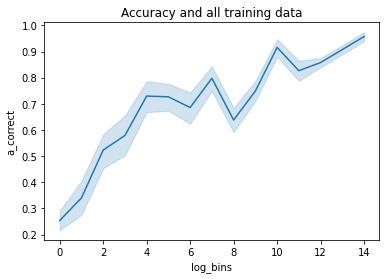

In [105]:
plt1 = sns.lineplot(x="log_bins", y="a_correct", data=link_lang_results_df, palette="muted")
plt1.set_title("Accuracy and all training data")

plt1.get_figure().savefig(os.path.join(os.path.dirname(file1), 'bin_accuracy.png'))

In [121]:
link_lang_results_df["log_total2"] = np.log10(link_lang_results_df["train_total2"]+1)
link_lang_results_df["log_bins2"] = pd.cut(link_lang_results_df["log_total2"], bins=15, labels=False)
link_lang_results_df["log_labels2"] = pd.cut(link_lang_results_df["log_total2"], bins=15)
link_lang_results_df["b_std"] = link_lang_results_df["b_correct"]
link_lang_results_df["binned_totals2"] = np.floor((link_lang_results_df["train_total2"] -1)/10.)
link_lang_results_df["binned_labels2"] = (link_lang_results_df["binned_totals2"] * 10) + 1

b_accuracy = pd.pivot_table(link_lang_results_df, index=['binned_totals2', 'binned_labels2'], 
                                 values=["b_correct","b_std", "train_bool"],
                            aggfunc={"b_correct": np.mean,"b_std": np.std,"train_bool": len})\
    .reset_index()
b_accuracy

,binned_totals2,binned_labels2,b_correct,b_std,train_bool
0,-1.0,-9.0,0.238223,0.426110,1868
1,0.0,1.0,0.525803,0.499577,1027
2,1.0,11.0,0.602076,0.490319,289
3,2.0,21.0,0.647059,0.478969,221
4,3.0,31.0,0.731707,0.443748,328
5,4.0,41.0,0.265823,0.444593,79
6,5.0,51.0,0.762791,0.426364,215
7,6.0,61.0,0.633333,0.483509,150
8,7.0,71.0,0.888889,0.323381,18
9,8.0,81.0,0.687500,0.466437,80


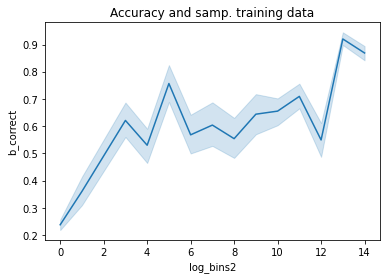

In [122]:
plt2 = sns.lineplot(x="log_bins2", y="b_correct", data=link_lang_results_df, palette="muted")
plt2.set_title("Accuracy and samp. training data")

plt2.get_figure().savefig(os.path.join(os.path.dirname(file2), 'bin_accuracy_samp.png'))

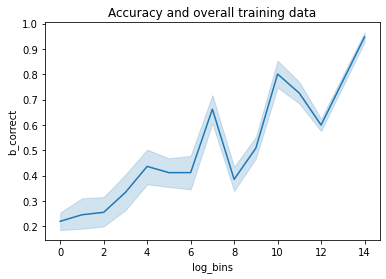

In [123]:
plt3 = sns.lineplot(x="log_bins", y="b_correct", data=link_lang_results_df, palette="muted")
plt3.set_title("Accuracy and overall training data")
plt3.get_figure().savefig(os.path.join(os.path.dirname(file2), 'bin_accuracy_all.png'))


In [109]:
link_lang_results_df["train_eng_ext"] = link_lang_results_df["train_eng"] > 0
link_lang_results_df["train_cmn_ext"] = link_lang_results_df["train_cmn"] > 0
link_lang_results_df["train_spa_ext"] = link_lang_results_df["train_spa"] > 0
link_lang_results_df


,a_correct,b_correct,lang,train_eng,train_spa,train_cmn,train_total,train_langs,train_eng2,train_spa2,...,a_std,log_total2,log_bins2,log_labels2,b_std,binned_totals2,binned_labels2,train_eng_ext,train_cmn_ext,train_spa_ext
0,True,False,SPA,240,67,128,435,"ENG,CMN,SPA",0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
1,True,False,SPA,240,67,128,435,"ENG,CMN,SPA",0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
2,True,False,SPA,240,67,128,435,"ENG,CMN,SPA",0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
3,True,False,SPA,240,67,128,435,"ENG,CMN,SPA",0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
4,True,False,SPA,240,67,128,435,"ENG,CMN,SPA",0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,True,False,CMN,0,0,552,552,CMN,0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,False,True,False
5500,True,False,CMN,0,0,552,552,CMN,0,0,...,True,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,False,True,False
5501,False,False,CMN,317,80,195,592,"ENG,CMN,SPA",0,0,...,False,0.0,0,"(-0.00171, 0.114]",False,-1.0,-9.0,True,True,True
5502,True,True,CMN,0,0,62,62,CMN,0,0,...,True,0.0,0,"(-0.00171, 0.114]",True,-1.0,-9.0,False,True,False


In [110]:
link_lang_pivot = pd.pivot_table(link_lang_results_df, index=['a_correct', "b_correct", 'lang', "train_bool2"], 
                                 values=[], 
                                 aggfunc=len)\
    .reset_index()
different1 = link_lang_pivot#[(link_lang_pivot["a_correct"] != link_lang_pivot['b_correct'])].reset_index()

different1 = different1.rename(columns={0:"count"})
different1

,a_correct,b_correct,lang,train_bool2,count
0,False,False,CMN,False,370
1,False,False,CMN,True,259
2,False,False,ENG,False,380
3,False,False,ENG,True,244
4,False,False,SPA,False,116
5,False,False,SPA,True,57
6,False,True,CMN,False,22
7,False,True,CMN,True,13
8,False,True,ENG,False,24
9,False,True,ENG,True,42


In [111]:
different2 = pd.pivot_table(different1, index=['a_correct', "b_correct", 'lang', "train_bool2"], 
                                 values=["count"], 
                                 aggfunc=sum).reset_index()
different2[different2['a_correct'] != different2['b_correct']]

,a_correct,b_correct,lang,train_bool2,count
6,False,True,CMN,False,22
7,False,True,CMN,True,13
8,False,True,ENG,False,24
9,False,True,ENG,True,42
10,False,True,SPA,False,13
11,False,True,SPA,True,7
12,True,False,CMN,False,1166
13,True,False,CMN,True,94
14,True,False,ENG,False,665
15,True,False,ENG,True,38


In [112]:
different3 = pd.pivot_table(different1, index=['a_correct', "b_correct", "train_bool2"], 
                                 values=["count"], 
                                 aggfunc=sum).reset_index()
different3

,a_correct,b_correct,train_bool2,count
0,False,False,False,866
1,False,False,True,560
2,False,True,False,59
3,False,True,True,62
4,True,False,False,2060
5,True,False,True,149
6,True,True,False,618
7,True,True,True,1130


In [113]:
#Looking at different data downsampling scenarios

data3 = data[data.lang.isin(["ENG"])]
#What if we don't include cross links?
no_cross_links = data3[~data3.link_id.isin(df_a['_gold_kbid'])]
data3

,system_id,query_id,mention_string,doc_id_offsets,link_id,entity_type,mention_type,confidence,web_search,wiki_text,unknown,lang
5445,LDC,TEDL15_TRAINING_05488,ISIS,ENG_NW_001059_20150120_F00000029:258-261,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5446,LDC,TEDL15_TRAINING_05489,ISIL,ENG_NW_001059_20150120_F00000029:269-272,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5447,LDC,TEDL15_TRAINING_05490,Islamic State,ENG_NW_001059_20150120_F00000029:280-292,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5448,LDC,TEDL15_TRAINING_05491,ISIL,ENG_NW_001059_20150120_F00000029:441-444,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5449,LDC,TEDL15_TRAINING_05492,Islamic State of Iraq and the Levant,ENG_NW_001059_20150120_F00000029:455-490,m.027x630,ORG,NAM,1.0,N,N,N,ENG
...,...,...,...,...,...,...,...,...,...,...,...,...
26112,LDC,TEDL15_TRAINING_26226,eastern Siberia,ENG_DF_001234_20150227_F0000008O:739-753,m.025t91x,LOC,NAM,1.0,N,Y,N,ENG
26113,LDC,TEDL15_TRAINING_26227,European,ENG_DF_001234_20150227_F0000008O:1933-1940,m.02j9z,LOC,NAM,1.0,N,Y,N,ENG
26114,LDC,TEDL15_TRAINING_26228,Right Sector,ENG_DF_001234_20150227_F0000008O:7815-7826,m.0_ljvdc,ORG,NAM,1.0,N,Y,N,ENG
26116,LDC,TEDL15_TRAINING_26230,North Korea,ENG_DF_001234_20150227_F0000008O:9718-9728,m.05b7q,GPE,NAM,1.0,N,Y,N,ENG


In [114]:
#What if only cross links?
cross_links = data3[data3.link_id.isin(df_a['_gold_kbid'])]
cross_links



,system_id,query_id,mention_string,doc_id_offsets,link_id,entity_type,mention_type,confidence,web_search,wiki_text,unknown,lang
5445,LDC,TEDL15_TRAINING_05488,ISIS,ENG_NW_001059_20150120_F00000029:258-261,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5446,LDC,TEDL15_TRAINING_05489,ISIL,ENG_NW_001059_20150120_F00000029:269-272,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5447,LDC,TEDL15_TRAINING_05490,Islamic State,ENG_NW_001059_20150120_F00000029:280-292,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5448,LDC,TEDL15_TRAINING_05491,ISIL,ENG_NW_001059_20150120_F00000029:441-444,m.027x630,ORG,NAM,1.0,N,N,N,ENG
5449,LDC,TEDL15_TRAINING_05492,Islamic State of Iraq and the Levant,ENG_NW_001059_20150120_F00000029:455-490,m.027x630,ORG,NAM,1.0,N,N,N,ENG
...,...,...,...,...,...,...,...,...,...,...,...,...
26106,LDC,TEDL15_TRAINING_26220,Litvenenko,ENG_DF_001234_20150227_F0000008O:9803-9813,m.026ndjg,PER,NAM,1.0,N,Y,N,ENG
26107,LDC,TEDL15_TRAINING_26221,China,ENG_DF_001234_20150227_F0000008O:719-723,m.0d05w3,GPE,NAM,1.0,N,Y,N,ENG
26110,LDC,TEDL15_TRAINING_26224,Syria,ENG_DF_001234_20150227_F0000008O:2161-2165,m.06vbd,GPE,NAM,1.0,N,Y,N,ENG
26113,LDC,TEDL15_TRAINING_26227,European,ENG_DF_001234_20150227_F0000008O:1933-1940,m.02j9z,LOC,NAM,1.0,N,Y,N,ENG


In [115]:
#What if only include at most n example of each link?
data3.sample(frac=1).groupby('link_id').head(19).reset_index(drop=True)


,system_id,query_id,mention_string,doc_id_offsets,link_id,entity_type,mention_type,confidence,web_search,wiki_text,unknown,lang
0,LDC,TEDL15_TRAINING_15884,Nemtsov,ENG_DF_001237_20150311_F00000094:89-95,m.05fz6q,PER,NAM,1.0,N,Y,N,ENG
1,LDC,TEDL15_TRAINING_07984,Reaganism,ENG_NW_001007_20140723_F00000006:3989-3997,m.06c0j,PER,NAM,1.0,N,N,N,ENG
2,LDC,TEDL15_TRAINING_10034,ISIS,ENG_NW_001035_20150317_F00000017:2846-2849,m.027x630,ORG,NAM,1.0,N,N,N,ENG
3,LDC,TEDL15_TRAINING_15693,Iraq,ENG_DF_001232_20150318_F0000008Z:5703-5706,m.0d05q4,GPE,NAM,1.0,N,Y,N,ENG
4,LDC,TEDL15_TRAINING_15173,Middle East,ENG_DF_001223_20150406_F0000007R:12076-12086,m.04wsz,LOC,NAM,1.0,N,N,N,ENG
...,...,...,...,...,...,...,...,...,...,...,...,...
3825,LDC,TEDL15_TRAINING_16219,Rubio,ENG_DF_001237_20150410_F0000007G:5884-5888,m.0dpr5f,PER,NAM,1.0,Y,N,N,ENG
3826,LDC,TEDL15_TRAINING_06442,Pretoria,ENG_NW_001009_20141021_F00000009:18334-18341,m.067z4,GPE,NAM,1.0,N,N,N,ENG
3827,LDC,TEDL15_TRAINING_15269,Hernandez,ENG_DF_001224_20150408_F0000008T:424-432,m.09g8zlg,PER,NAM,1.0,N,N,N,ENG
3828,LDC,TEDL15_TRAINING_16744,Eurasia,ENG_DF_001237_20150411_F00000093:8548-8554,m.02qkt,LOC,NAM,1.0,N,N,N,ENG


In [116]:
#What if we select n random rows?
rand = data3.sample(n=1000)
rand.groupby('link_id').head(1).reset_index(drop=True)


,system_id,query_id,mention_string,doc_id_offsets,link_id,entity_type,mention_type,confidence,web_search,wiki_text,unknown,lang
0,LDC,TEDL15_TRAINING_18711,One Direction,ENG_DF_000183_20150407_F0000009E:8758-8770,m.0fqqnpw,ORG,NAM,1.0,N,N,N,ENG
1,LDC,TEDL15_TRAINING_14955,Bin Laden,ENG_DF_001219_20150316_F0000007C:3299-3307,m.05mg9,PER,NAM,1.0,N,N,N,ENG
2,LDC,TEDL15_TRAINING_08624,highway,ENG_NW_001016_20150227_F0000000I:5830-5836,m.028k8j,FAC,NAM,1.0,N,Y,N,ENG
3,LDC,TEDL15_TRAINING_08165,Netanyahu,ENG_NW_001041_20150317_F0000001H:2562-2570,m.0fm2h,PER,NAM,1.0,N,N,N,ENG
4,LDC,TEDL15_TRAINING_14123,Putin,ENG_DF_001206_20150301_F0000007N:1978-1984,m.08193,PER,NAM,1.0,N,N,N,ENG
...,...,...,...,...,...,...,...,...,...,...,...,...
315,LDC,TEDL15_TRAINING_10049,UUP,ENG_NW_001035_20150317_F00000017:2387-2389,m.0j8cs,ORG,NAM,1.0,N,Y,N,ENG
316,LDC,TEDL15_TRAINING_07470,Olusegun Obasanjo,ENG_NW_001003_20150320_F00000002:578-594,m.021tjd,PER,NAM,1.0,N,N,N,ENG
317,LDC,TEDL15_TRAINING_06152,West Bank,ENG_NW_001040_20150323_F0000001F:12803-12811,m.082pc,LOC,NAM,1.0,N,Y,N,ENG
318,LDC,TEDL15_TRAINING_09591,AMISOM,ENG_NW_001013_20150313_F0000000D:5583-5588,m.0g_sw6,ORG,NAM,1.0,N,Y,N,ENG


In [117]:
data3['link_count'] = data3['link_id'].map(data3['link_id'].value_counts())
sorted_data3 = data3.sort_values("link_count", ascending=False)
sorted_data3.head(int(len(sorted_data3) * 0.5))

/Users/elliotschumacher/.conda/envs/clel/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,system_id,query_id,mention_string,doc_id_offsets,link_id,entity_type,mention_type,confidence,web_search,wiki_text,unknown,lang,link_count
15066,LDC,TEDL15_TRAINING_15124,America,ENG_DF_001222_20150428_F00000096:13807-13813,m.09c7w0,GPE,NAM,1.0,N,N,N,ENG,493
13934,LDC,TEDL15_TRAINING_13988,U.S.,ENG_DF_001203_20150407_F0000007Y:557-560,m.09c7w0,GPE,NAM,1.0,N,N,N,ENG,493
13841,LDC,TEDL15_TRAINING_13895,America,ENG_DF_001201_20150324_F00000079:17456-17462,m.09c7w0,GPE,NAM,1.0,N,N,N,ENG,493
13840,LDC,TEDL15_TRAINING_13894,America,ENG_DF_001201_20150324_F00000079:15151-15157,m.09c7w0,GPE,NAM,1.0,N,N,N,ENG,493
13839,LDC,TEDL15_TRAINING_13893,America,ENG_DF_001201_20150324_F00000079:15126-15132,m.09c7w0,GPE,NAM,1.0,N,N,N,ENG,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020,LDC,TEDL15_TRAINING_15078,Kenya,ENG_DF_001220_20150404_F0000007K:264-268,m.019rg5,GPE,NAM,1.0,Y,Y,N,ENG,54
6967,LDC,TEDL15_TRAINING_07015,Kenyan,ENG_NW_001057_20150402_F00000026:266-271,m.019rg5,GPE,NAM,1.0,N,Y,N,ENG,54
8688,LDC,TEDL15_TRAINING_08739,Kenyan,ENG_NW_001001_20150404_F00000000:162-167,m.019rg5,GPE,NAM,1.0,N,Y,N,ENG,54
6966,LDC,TEDL15_TRAINING_07014,Kenya,ENG_NW_001057_20150402_F00000026:237-241,m.019rg5,GPE,NAM,1.0,N,Y,N,ENG,54
